In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import warnings

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
# Data source: https://www.kaggle.com/datasets/sushobhitlutade/inventorysupply-chain-managementscm-superstore/data?select=Brand.csv
# US holiday 2004-2021 data: https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021?select=US+Holiday+Dates+%282004-2021%29.csv

In [ ]:
#download data
# https://drive.google.com/file/d/1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7/view?usp=sharing
# https://drive.google.com/file/d/1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ/view?usp=sharing

dwn_url='https://drive.google.com/uc?id='
# df_id = dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7"
df_trans = pd.read_csv(dwn_url+"1zLUFEgysYJIL0oAA7WIiv0eogs8xUel7") #transactions data
df_prod = pd.read_csv(dwn_url+"1gevzcsdgYnpcMVUJBhOe3z6QsIPK7GJZ") #products data

#deletes white spaces on column tittles
df_trans.columns = [col.strip() for col in df_trans.columns]
df_prod.columns = [col.strip() for col in df_prod.columns]

#transforms date column to datetime format
df_trans["Transaction_date"] = pd.to_datetime(df_trans["Transaction_date"], format = "%Y-%m-%d")

#Clean transaction table, delete unnecessary columns (Payment_Method, Customer_Cart, Cashier)
df_trans = df_trans.drop(columns=['Payment_Method', 'CustomerCart_CustomerID','Cashier_CashierID'])

#Clean data to show only 2014-2017 data
df_trans=df_trans[df_trans["Transaction_date"].dt.year <= 2017]


In [ ]:
#create column for Units Sold
df_trans['Units_Sold'] = df_trans['Quantity']

#delete column named 'Quantity' for better column lableling/understanding
df_trans = df_trans.drop(columns=['Quantity'])

#add columns to Transaction Table
df_trans['Cat-SubCat_ID']= df_trans['Products_ProductID'].str[:6]
df_trans['Cat_ID']= df_trans['Products_ProductID'].str[:3] #first 3 letters of Category ID
df_trans['SubCat_ID']= df_trans['Products_ProductID'].str[4:6] #first 2 letters of SubCategory ID
df_trans['Quarter'] = df_trans['Transaction_date'].dt.quarter
df_trans['Year']= df_trans['Transaction_date'].dt.year
df_trans['Month']= df_trans['Transaction_date'].dt.month
df_trans['Day_of_Year']= df_trans['Transaction_date'].dt.day_of_year
df_trans['Year-Month'] = df_trans['Transaction_date'].dt.to_period('M')
df_trans['Day_of_the_Week']= df_trans['Transaction_date'].dt.day_name()


In [ ]:
df_trans

,Transaction_date,Subtotal,Taxes,DiscountPrice,TotalAmount,Products_ProductID,Units_Sold,Cat-SubCat_ID,Cat_ID,SubCat_ID,Quarter,Year,Month,Day_of_Year,Year-Month,Day_of_the_Week
0,2016-11-11,261.96,11.46,78.59,273.42,FUR-BO-10001798,2,FUR-BO,FUR,BO,4,2016,11,316,2016-11,Friday
1,2016-11-11,512.36,22.42,153.71,534.77,FUR-CH-10000454,3,FUR-CH,FUR,CH,4,2016,11,316,2016-11,Friday
2,2016-06-16,14.62,0.91,0.00,15.53,OFF-LA-10000240,2,OFF-LA,OFF,LA,2,2016,6,168,2016-06,Thursday
3,2015-10-18,957.58,41.89,287.27,999.47,FUR-TA-10000577,5,FUR-TA,FUR,TA,4,2015,10,291,2015-10,Sunday
4,2015-10-18,27.96,1.57,2.80,29.53,OFF-ST-10000760,2,OFF-ST,OFF,ST,4,2015,10,291,2015-10,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,2014-01-23,75.74,4.26,7.57,80.00,FUR-FU-10001889,3,FUR-FU,FUR,FU,1,2014,1,23,2014-01,Thursday
9990,2017-03-03,91.96,5.17,9.20,97.13,FUR-FU-10000747,2,FUR-FU,FUR,FU,1,2017,3,62,2017-03,Friday
9991,2017-03-03,323.22,14.14,96.97,337.36,TEC-PH-10003645,2,TEC-PH,TEC,PH,1,2017,3,62,2017-03,Friday
9992,2017-03-03,71.04,4.00,7.10,75.04,OFF-PA-10004041,4,OFF-PA,OFF,PA,1,2017,3,62,2017-03,Friday


In [ ]:
#Groupby to create dataframe of items sold per year
items_per_year = df_trans.groupby(['Products_ProductID','Cat-SubCat_ID','Cat_ID','Year']).Units_Sold.sum().reset_index()
#create column that counts the instances of the item in the DataFrame - counts the number of years the product was sold (between 2014-2017)
items_per_year['No. Years sold'] = items_per_year.groupby(['Products_ProductID']).transform('size')

items_per_year

,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
0,FUR-BO-10000112,FUR-BO,FUR,2017,9,1
1,FUR-BO-10000330,FUR-BO,FUR,2014,4,3
2,FUR-BO-10000330,FUR-BO,FUR,2015,4,3
3,FUR-BO-10000330,FUR-BO,FUR,2017,2,3
4,FUR-BO-10000362,FUR-BO,FUR,2014,8,3
...,...,...,...,...,...,...
5347,TEC-PH-10004959,TEC-PH,TEC,2015,1,2
5348,TEC-PH-10004977,TEC-PH,TEC,2014,6,4
5349,TEC-PH-10004977,TEC-PH,TEC,2015,2,4
5350,TEC-PH-10004977,TEC-PH,TEC,2016,7,4


In [ ]:
subcat_per_year = df_trans.groupby(['Cat-SubCat_ID','Year']).Units_Sold.sum().reset_index()
#subcat_per_year['No. Years sold'] = items_per_year.groupby(['Cat-SubCat_ID']).transform('size')

subcat_per_year.sort_values(['Units_Sold'], ascending=False).head(50).reset_index().head()

,index,Cat-SubCat_ID,Year,Units_Sold
0,27,OFF-BI,2017,2051
1,43,OFF-PA,2017,1706
2,26,OFF-BI,2016,1615
3,42,OFF-PA,2016,1363
4,25,OFF-BI,2015,1195


In [ ]:
Items_all_4_years = items_per_year[items_per_year['No. Years sold']== 4]
Items_all_4_years

,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
7,FUR-BO-10000468,FUR-BO,FUR,2014,4,4
8,FUR-BO-10000468,FUR-BO,FUR,2015,4,4
9,FUR-BO-10000468,FUR-BO,FUR,2016,1,4
10,FUR-BO-10000468,FUR-BO,FUR,2017,12,4
15,FUR-BO-10001337,FUR-BO,FUR,2014,14,4
...,...,...,...,...,...,...
5337,TEC-PH-10004908,TEC-PH,TEC,2017,1,4
5348,TEC-PH-10004977,TEC-PH,TEC,2014,6,4
5349,TEC-PH-10004977,TEC-PH,TEC,2015,2,4
5350,TEC-PH-10004977,TEC-PH,TEC,2016,7,4


In [ ]:
Items_all_4_years.sort_values(['Units_Sold'], ascending=False)


,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
4627,TEC-AC-10003832,TEC-AC,TEC,2016,41,4
424,FUR-FU-10000023,FUR-FU,FUR,2017,31,4
2522,OFF-BI-10004728,OFF-BI,OFF,2016,30,4
3469,OFF-PA-10002377,OFF-PA,OFF,2017,30,4
1891,OFF-BI-10000301,OFF-BI,OFF,2017,29,4
...,...,...,...,...,...,...
3527,OFF-PA-10002893,OFF-PA,OFF,2017,1,4
2625,OFF-EN-10002504,OFF-EN,OFF,2015,1,4
2916,OFF-LA-10001771,OFF-LA,OFF,2016,1,4
994,FUR-TA-10001768,FUR-TA,FUR,2017,1,4


In [ ]:
Items_3_to_4_years = items_per_year[items_per_year['No. Years sold']>= 3]
Items_3_to_4_years

,Products_ProductID,Cat-SubCat_ID,Cat_ID,Year,Units_Sold,No. Years sold
1,FUR-BO-10000330,FUR-BO,FUR,2014,4,3
2,FUR-BO-10000330,FUR-BO,FUR,2015,4,3
3,FUR-BO-10000330,FUR-BO,FUR,2017,2,3
4,FUR-BO-10000362,FUR-BO,FUR,2014,8,3
5,FUR-BO-10000362,FUR-BO,FUR,2015,5,3
...,...,...,...,...,...,...
5343,TEC-PH-10004922,TEC-PH,TEC,2017,3,3
5348,TEC-PH-10004977,TEC-PH,TEC,2014,6,4
5349,TEC-PH-10004977,TEC-PH,TEC,2015,2,4
5350,TEC-PH-10004977,TEC-PH,TEC,2016,7,4


interactive(children=(Dropdown(description='categories', options=('FUR-BO', 'FUR-CH', 'OFF-LA', 'FUR-TA', 'OFF…

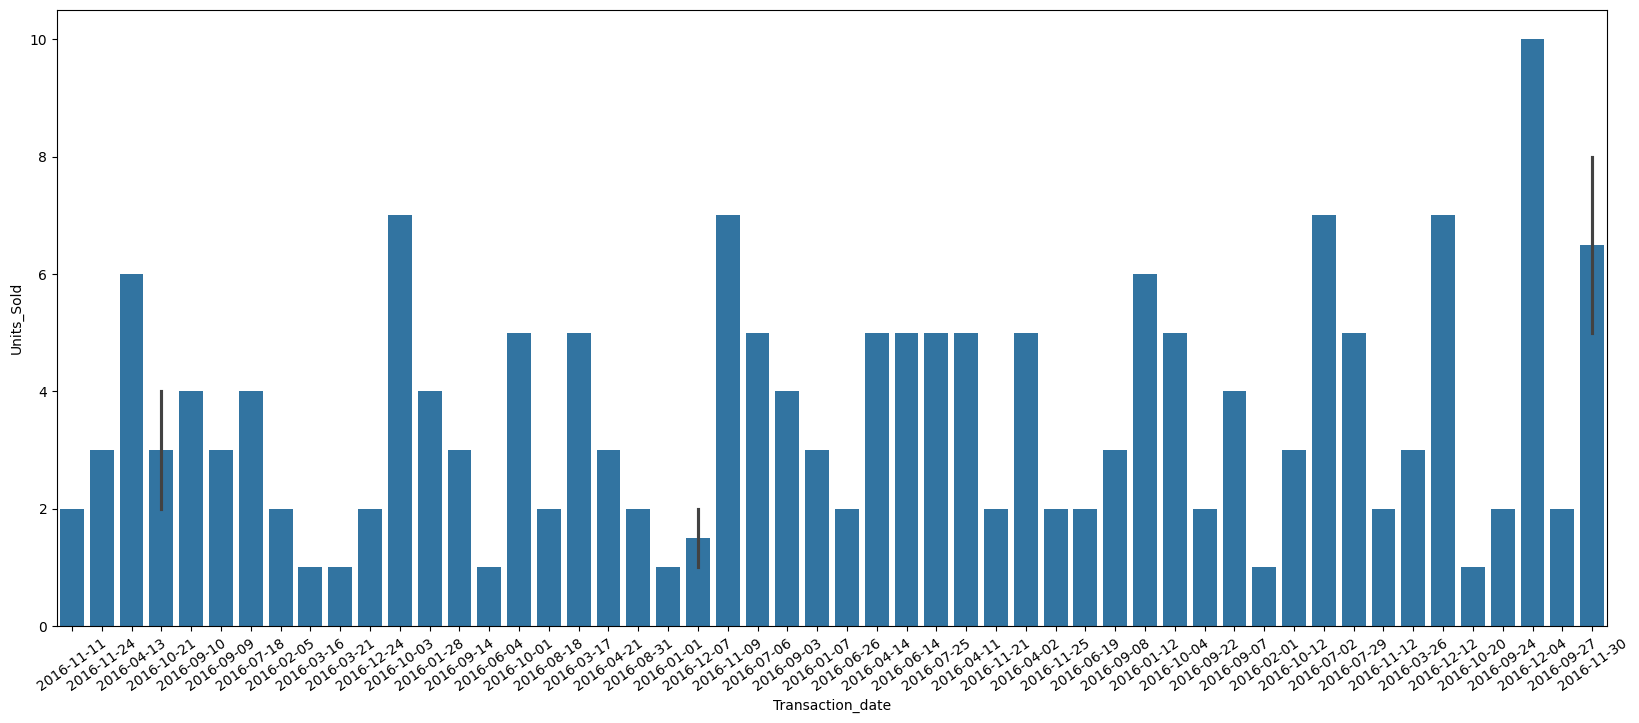

In [ ]:
@interact
def scatter_plot(categories = df_trans['Cat-SubCat_ID'].unique(), year = df_trans['Year'].unique()):
    cond1 = df_trans['Cat-SubCat_ID'] == categories
    cond2 = df_trans['Year'] == year

    plt.figure(figsize=(20, 8))
    sns.barplot(
    data= df_trans[cond1][cond2],
    x = 'Transaction_date',
    y = 'Units_Sold'
    );
    plt.tick_params(axis='x', rotation=35);

interactive(children=(Dropdown(description='categories', options=('FUR', 'OFF', 'TEC'), value='FUR'), Output()…

<Figure size 4000x800 with 0 Axes>

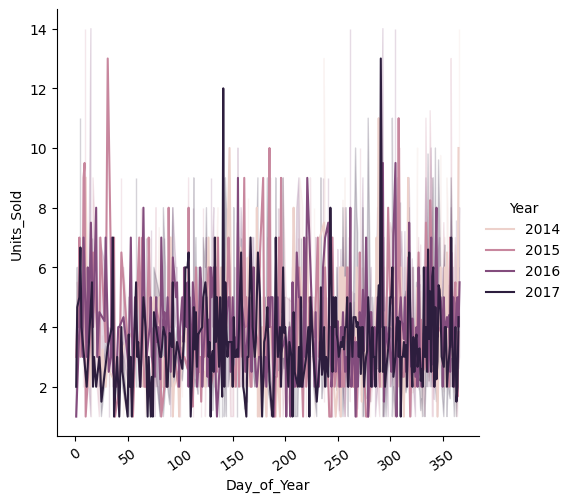

In [ ]:
@interact
def scatter_plot(categories = df_trans['Cat_ID'].unique()):
    cond1 = df_trans['Cat_ID'] == categories
    #cond2 = df_trans['Year'] == year

    plt.figure(figsize=(40, 8))
    sns.relplot(
    data= df_trans[cond1],
    kind='line',
    x = 'Day_of_Year',
    y = 'Units_Sold',
    hue= 'Year',
    #ax = axes[1]
    );
    plt.tick_params(axis='x', rotation=35);

In [ ]:
# Instead of one item, we choose one sub-catagory 'OFF-BI'.

# df_subcat = df_trans.query("'Cat-SubCat_ID' == 'OFF-BI'").sort_values(["Transaction_date"], axis=0, ascending=[True])

df_OFF_BI = df_trans.query("`Cat-SubCat_ID` == 'OFF-BI'")
df_OFF_BI = df_OFF_BI.sort_values(["Transaction_date"], axis=0, ascending=[True])

df_OFF_BI

,Transaction_date,Subtotal,Taxes,DiscountPrice,TotalAmount,Products_ProductID,Units_Sold,Cat-SubCat_ID,Cat_ID,SubCat_ID,Quarter,Year,Month,Day_of_Year,Year-Month,Day_of_the_Week
741,2014-01-08,5.31,0.33,0.00,5.64,OFF-BI-10004094,2,OFF-BI,OFF,BI,1,2014,1,8,2014-01,Wednesday
7475,2014-01-10,41.44,2.33,4.14,43.77,OFF-BI-10004632,2,OFF-BI,OFF,BI,1,2014,1,10,2014-01,Friday
7661,2014-01-12,31.29,1.96,0.00,33.25,OFF-BI-10003708,7,OFF-BI,OFF,BI,1,2014,1,12,2014-01,Sunday
766,2014-01-15,11.28,0.71,0.00,11.99,OFF-BI-10004187,3,OFF-BI,OFF,BI,1,2014,1,15,2014-01,Wednesday
9629,2014-01-18,6.88,0.43,0.00,7.31,OFF-BI-10003476,2,OFF-BI,OFF,BI,1,2014,1,18,2014-01,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6806,2017-12-29,1.93,0.12,0.00,2.05,OFF-BI-10003314,1,OFF-BI,OFF,BI,4,2017,12,363,2017-12,Friday
8855,2017-12-30,15.98,1.00,0.00,16.98,OFF-BI-10001679,3,OFF-BI,OFF,BI,4,2017,12,364,2017-12,Saturday
2424,2017-12-30,8.68,0.54,0.00,9.22,OFF-BI-10000632,1,OFF-BI,OFF,BI,4,2017,12,364,2017-12,Saturday
3785,2017-12-30,2.09,0.13,0.00,2.22,OFF-BI-10000494,2,OFF-BI,OFF,BI,4,2017,12,364,2017-12,Saturday


In [ ]:
df_subcat.dtypes

Transaction_date      datetime64[ns]
Subtotal                     float64
Taxes                        float64
DiscountPrice                float64
TotalAmount                  float64
Products_ProductID            object
Units_Sold                     int64
Cat-SubCat_ID                 object
Cat_ID                        object
SubCat_ID                     object
Quarter                        int32
Year                           int32
Month                          int32
Day_of_Year                    int32
Year-Month                 period[M]
Day_of_the_Week               object
dtype: object

In [ ]:
df_subcat.isna().sum()

Transaction_date      0
Subtotal              0
Taxes                 0
DiscountPrice         0
TotalAmount           0
Products_ProductID    0
Units_Sold            0
Cat-SubCat_ID         0
Cat_ID                0
SubCat_ID             0
Quarter               0
Year                  0
Month                 0
Day_of_Year           0
Year-Month            0
Day_of_the_Week       0
dtype: int64

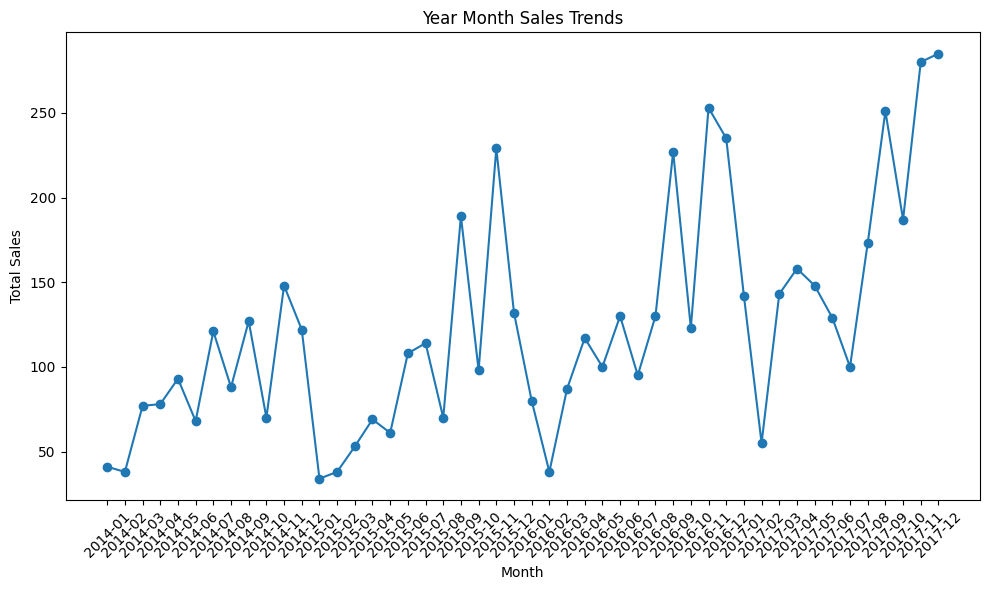

In [ ]:

# Group data and reset index to get a DataFrame
df_grouped = df_subcat.groupby(['Year-Month'])['Units_Sold'].sum().reset_index()

# Convert 'Year-Month' to string for plotting
df_grouped['Year-Month'] = df_grouped['Year-Month'].astype(str)

# Plot the line graph with correct labels and title
plt.figure(figsize=(10, 6))  # Adjust figure size as desired
plt.plot(df_grouped['Year-Month'], df_grouped['Units_Sold'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Year Month Sales Trends')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [ ]:
# https://drive.google.com/file/d/1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK/view?usp=sharing
dwn_url='https://drive.google.com/uc?id='
#df_id = dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
df_holiday = pd.read_csv(
    dwn_url+"1wFQTKwfvLRoxL0Ky7K4Yd2-jxUKs0IwK"
)

In [ ]:
df_holiday

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008
...,...,...,...,...,...,...
337,2006-04-16,Western Easter,Sunday,4,16,2006
338,2017-04-16,Western Easter,Sunday,4,16,2017
339,2014-04-20,Western Easter,Sunday,4,20,2014
340,2019-04-21,Western Easter,Sunday,4,21,2019


In [ ]:
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])

In [ ]:
df_holiday.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     342 non-null    datetime64[ns]
 1   Holiday  342 non-null    object        
 2   WeekDay  342 non-null    object        
 3   Month    342 non-null    int64         
 4   Day      342 non-null    int64         
 5   Year     342 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 16.2+ KB


In [ ]:
start_date = '2014-01-01'
end_date = '2018-12-31'

df_hld = df_holiday[(df_holiday['Date'] >= start_date) & (df_holiday['Date'] <= end_date)]

In [ ]:
df_hld

,Date,Holiday,WeekDay,Month,Day,Year
10,2014-07-04,4th of July,Friday,7,4,2014
11,2015-07-04,4th of July,Saturday,7,4,2015
12,2016-07-04,4th of July,Monday,7,4,2016
13,2017-07-04,4th of July,Tuesday,7,4,2017
14,2018-07-04,4th of July,Wednesday,7,4,2018
...,...,...,...,...,...,...
326,2016-03-27,Western Easter,Sunday,3,27,2016
328,2018-04-01,Western Easter,Sunday,4,1,2018
331,2015-04-05,Western Easter,Sunday,4,5,2015
338,2017-04-16,Western Easter,Sunday,4,16,2017


In [ ]:
df_hld['Holiday'].value_counts()

Holiday
Labor Day Weekend              10
4th of July                     5
New Year's Day                  5
Washington's Birthday           5
Veterans Day                    5
Valentine’s Day                 5
Thanksgiving Eve                5
Thanksgiving Day                5
New Year’s Eve                  5
Memorial Day                    5
Christmas Day                   5
Martin Luther King, Jr. Day     5
Labor Day                       5
Juneteenth                      5
Eastern Easter                  5
Columbus Day                    5
Christmas Eve                   5
Western Easter                  5
Name: count, dtype: int64